# Exploración de datos de sesiones web

## Estructura básica de los datos

La base de datos manejada para este proyecto contiene información sobre sesiones de los usuarios de sitio de nosfuimos. En particular, los datos sobre cada sesión contienen información sobre las páginas visitadas, tiempo de inicio y fin, y el usuario que realizó la sesión.

In [2]:
import MySQLdb as mdb
import pandas as pd

con = mdb.connect("127.0.0.1", "guidecapture", "guidecapture", "guide_informe_final_corfo")
with con:
    cur = con.cursor()
    cur.execute("SELECT id, sequence, user_id, inittime, endtime FROM sessions;")
    rows = cur.fetchall()
    df = pd.DataFrame([[attribute for attribute in session] for session in rows])
    df.rename(columns={0:"id", 1:"sesión", 2:"usuario", 3:"inittime", 4:"endtime"}, inplace=True)

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: context interface will be changed.  Use explicit conn.commit() or conn.rollback().
  """


,id,sesión,usuario,inittime,endtime
0,1,1 19,1,2016-05-12 10:12:04,2016-05-12 10:13:27
1,2,19,1,2016-05-12 10:15:17,2016-05-12 10:16:27
2,3,19 1 1 19 19,1,2016-05-12 10:18:28,2016-05-12 10:21:28
3,4,1,1,2016-05-12 11:03:31,2016-05-12 11:03:38
4,5,1 14 14 1 1 32 32,1,2016-05-12 11:07:12,2016-05-12 11:11:36


## Hipótesis

A priori, planteamos la hipótesis de que existe alguna diferencia entre características de las sesiones como número de páginas visitadas, o tiempo que lleva a cabo, tal que se pueda hacer una clusterización sobre los datos.

## Metodologías usadas y a seguir

La metodología básica usada en este proyecto es extraer y analizar datos de una base de datos generada por código entregado por el Profesor Pablo Guerrero.

Dado que el análisis es relativamente liviano, sólo se utiliza la CPU, con librerías de python para analizar y visualizar los datos, como `matplotlib` y `pandas`.

## Análisis

El análisis puede ser comenzado viendo cómo se distribuyen los datos entre el total de usuarios.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

session_visits = np.asarray([len(s.split(" ")) for s in df['sesión']])

fig, (linear, log) = plt.subplots(ncols=2, figsize=(15,5))

linear.hist(session_visits, bins=30)
linear.set_title("Número de visitas por sesión")
linear.set_ylabel("Frecuencia")
linear.set_xlabel("Número de visitas")

log.hist(session_visits, bins=30)
log.semilogy(2)
log.set_title("Número de visitas por sesión")
log.set_ylabel("log(Frecuencia)")
log.set_xlabel("Número de visitas")
plt.show()

<Figure size 1500x500 with 2 Axes>

Los otros atributos importantes, son inittime y endtime, los cuales obviamente ilustran cuando se comienza una sesión, y cuando se termina. Podemos similarmente ver la distribución de estos tiempos para todas las distintas sesiones.

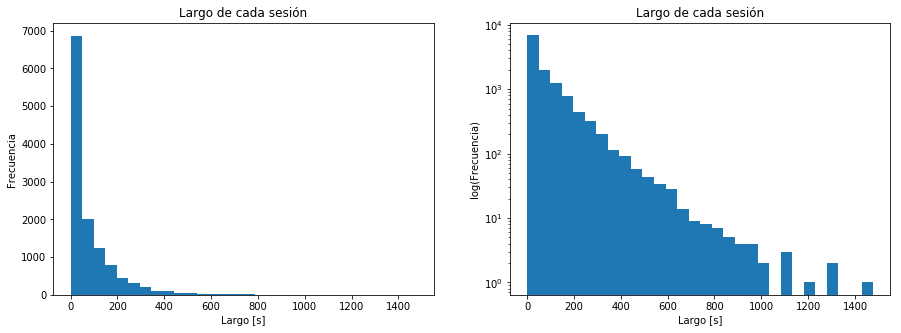

In [5]:
session_lengths = np.asarray([int((end - start).total_seconds()) for start, end in zip(df['inittime'], df['endtime'])])


fig, (linear, log) = plt.subplots(ncols=2, figsize=(15,5))

linear.hist(session_lengths, bins=30)
linear.set_title("Largo de cada sesión")
linear.set_ylabel("Frecuencia")
linear.set_xlabel("Largo [s]")

log.hist(session_lengths, bins=30)
log.semilogy(2)
log.set_title("Largo de cada sesión")
log.set_ylabel("log(Frecuencia)")
log.set_xlabel("Largo [s]")
plt.show()

Podemos graficar ambos atributos juntos, para ver si a priori se distinguen grupos de comportamientos similares.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


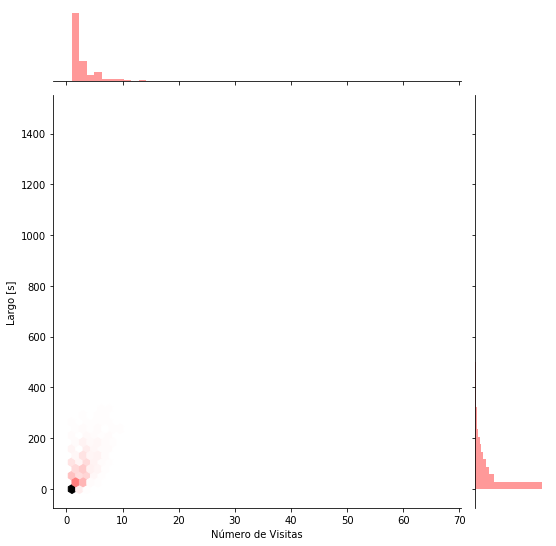

In [6]:
import seaborn as sns

g = sns.jointplot(x=session_visits, y=session_lengths, kind="hex", stat_func=None, size=7.5, color="r")
g.set_axis_labels("Número de Visitas", "Largo [s]")
plt.show()

Es bastante obvio que entre estas medidas iniciales no se pueden observar clusters, por lo que se deben buscar algunas métricas nuevas sobre cada sesión. Proponemos una medida de auto-similaridad de cada sesión, la cual indica cuantas veces una misma sesión repite sus propios pasos, es decir, pasa más de una ves por el mismo sitio. Definimos la originalidad $\theta$ de una sesión $s={p_1,p_2,\ldots,p_n}$ como:

$$ \theta = \Sigma c_{p_{i}}^{-1}$$

Donde $c_{p_i}$ es el número de veces que la página $p_i$ fue visitada en la sesión $s$. Esta medida es 1 cuando no se repite ninguna página, y se acerca a cero mientras más páginas se repiten en una sesión.

In [8]:
def total_visits(session):
    visits = session.split(" ")
    total_visits = {}
    for v in visits:
        if v in total_visits:
            total_visits[v] += 1
        else:
            total_visits[v] = 1
    return total_visits

def originality(total_visits):
    sum = 0
    for k in total_visits:
        sum += 1 / total_visits[k]
    return sum / len(total_visits)

session_orig = np.asarray([originality(total_visits(s)) for s in df['sesión']])

Para visualizar esta medida, podemos graficar la frecuencia de estas originalidades, para ver si sale a la luz algúna característica distintiva.

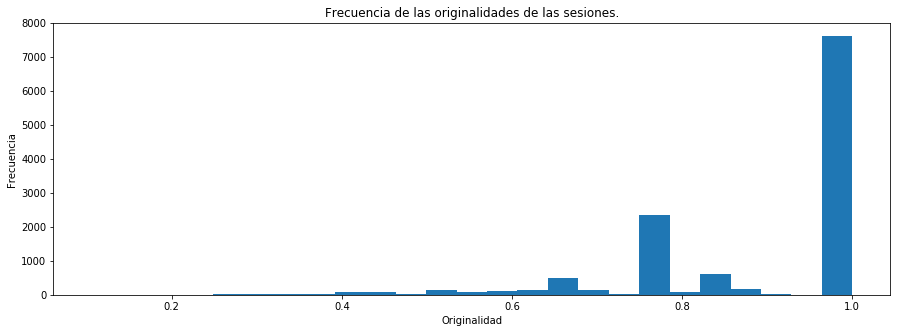

In [9]:
plt.figure(figsize=(15,5))
ax = plt.gca()
plt.hist(session_orig, bins=25)
ax.set_title("Frecuencia de las originalidades de las sesiones.")
ax.set_xlabel("Originalidad")
ax.set_ylabel("Frecuencia")

plt.show()

Ahora se vuelve bastante claro que esta medida nos genera dos grupos distintos de sesiones en el dataset. A priori podríamos decir que existen entonces dos tipos de sesiones a base de esta medida, aquellos que entran a la página, revisan un par de páginas y se van, y aquellos que se dan un par de vueltas por el sitio, repitiendo páginas antes de irse.

Para comprobar esta hipótesis, debemos primero comparar como es el comportamiento de la originalidad versus el número de páginas visitadas en una sesión. Si la hipótesis es correcta, entonces la mayoría de los puntos con alta originalidad, deberían tener un bajo número de sesiones.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


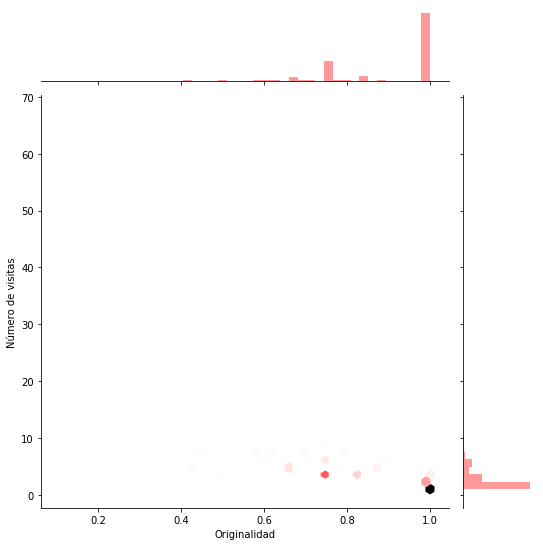

In [10]:
g =sns.jointplot(x=session_orig, y=session_visits, kind="hex", stat_func=None, size=7.5, color="r")
g.set_axis_labels("Originalidad","Número de visitas")
plt.show()

Pese a la buena distribución de la originalidad, el número de visitas no aporta mucha más información, dado que la mayoría de las sesiones con menor originalidad, también tienen bajo número de sesiones. Por esto también podría ser interesante utilizar las páginas en específico por las que se pasó en la sesión, y ver que efecto tienen en la originalidad.

In [11]:
page_visits = pd.DataFrame(session_orig)
page_visits.rename(columns={0: 'originality'}, inplace=True)

for i, s in enumerate(df['sesión']):
    visits = total_visits(s)
    for k in visits:
        if k not in page_visits:
            kwargs = {k: lambda _: 0}
            page_visits = page_visits.assign(**kwargs)
        page_visits.loc[i, k] = visits[k]

page_visits.head()

,originality,1,19,14,32,29,20,6,16,11,...,8,22,21,27,24,23,26,31,28,30
0,1.000000,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.000000,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.416667,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.000000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.444444,3,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Para realizar el análisis de relación entre originalidad y páginas visitadas, podemos hacer un PCA sobre todas las página y cuantas veces han sido visitadas en cada sesión.

In [12]:
pages = page_visits.iloc[:,1:]
orig = page_visits.iloc[:, 0]

from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer

imp = Imputer()
X_imp = imp.fit(pages).transform(pages)

pca = PCA(n_components=2)
X=pca.fit(X_imp).transform(X_imp)

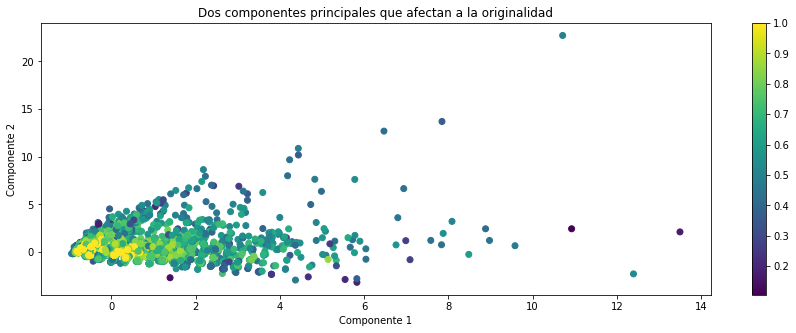

In [13]:
plt.figure(figsize=(15,5))
ax = plt.gca()
plt.scatter(X[:,0], X[:,1],c=orig, cmap="viridis")
plt.colorbar()
ax.set_title("Dos componentes principales que afectan a la originalidad")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
plt.show()

Es claro que las páginas visitadas tienen algo de relación con la originalidad de la sesión final, pero a fin de cuentas no es lo que buscamos.

## Conclusiones

Con este análisis exploratorio, es claro ver que no existe una clusterización obvia en el dataset como se pensaba. Por lo tanto se deben crear métricas como la originalidad mencionada anteriormente y observar su efectividad en segmentar los datos, para encontrar alguna clusterización que diferencie los distintos tipos de sesiones.

### Código fuente
El código fuente de este proyecto se encuentra en [este repositorio](https://github.com/danno-s/proyecto-bayes "Repositorio del proyecto."), junto a un archivo de requerimientos para ejecutar este notebook.